In [1]:
!pip install -U numpy pandas pyarrow matplotlib scipy
import sys, subprocess
try:
    import psutil  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "psutil"])
print("psutil is installed.")


from IPython.core.magic import register_cell_magic
import time, os, platform

# Try to import optional modules
try:
    import psutil
except Exception:
    psutil = None

try:
    import resource  # not available on Windows
except Exception:
    resource = None


def _rss_bytes():
    """Resident Set Size in bytes (cross-platform via psutil if available)."""
    if psutil is not None:
        return psutil.Process(os.getpid()).memory_info().rss
    # Fallback: unknown RSS → 0 
    return 0


def _peak_bytes():
    """
    Best-effort peak memory in bytes.
    - Windows: psutil peak working set (peak_wset)
    - Linux:   resource.ru_maxrss (KB → bytes)
    - macOS:   resource.ru_maxrss (bytes)
    Fallback to current RSS if unavailable.
    """
    sysname = platform.system()

    # Windows path: use psutil peak_wset if present
    if sysname == "Windows" and psutil is not None:
        mi = psutil.Process(os.getpid()).memory_info()
        peak = getattr(mi, "peak_wset", None)  # should be available on Windows
        if peak is not None:
            return int(peak)
        return int(mi.rss)

    # POSIX path: resource may be available
    if resource is not None:
        try:
            ru = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            # On Linux ru_maxrss is in kilobytes; on macOS/BSD it is bytes
            if sysname == "Linux":
                return int(ru) * 1024
            else:
                return int(ru)
        except Exception:
            pass

    # Last resort
    return _rss_bytes()


@register_cell_magic
def timemem(line, cell):
    """
    Measure wall time and memory around the execution of this cell.

        %%timemem
        <your code>

    Notes:
    - RSS = resident memory after the cell.
    - Peak is OS-dependent (see _peak_bytes docstring).
    """
    ip = get_ipython()

    rss_before  = _rss_bytes()
    peak_before = _peak_bytes()
    t0 = time.perf_counter()

    # Execute the cell body
    result = ip.run_cell(cell)

    t1 = time.perf_counter()
    rss_after  = _rss_bytes()
    peak_after = _peak_bytes()

    wall = t1 - t0
    rss_delta_mb  = (rss_after  - rss_before)  / (1024 * 1024)
    peak_delta_mb = (peak_after - peak_before) / (1024 * 1024)

    print("======================================")
    print(f"Wall time: {wall:.3f} s")
    print(f"RSS Δ: {rss_delta_mb:+.2f} MB")
    print(f"Peak memory Δ: {peak_delta_mb:+.2f} MB (OS-dependent)")
    print("======================================")

    return result

psutil is installed.


In [2]:
import findspark, os, sys

# ==================== CONFIGURATION SPARK ====================

# Utilise le Spark trouvé sur ta machine Linux
spark_home = "/home/bibawandaogo/spark-4.0.1-bin-hadoop3"
os.environ["SPARK_HOME"] = spark_home

print(f"SPARK_HOME: {spark_home}")

# Initialise findspark
findspark.init(spark_home)

# ==================== IMPORTS PYSPARK ====================

from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.functions import broadcast

# ==================== CONFIGURATION PYTHON ====================

py = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = py
os.environ["PYSPARK_PYTHON"] = py

# ==================== SPARK SESSION ====================

spark = SparkSession.getActiveSession() or (
    SparkSession.builder
    .appName("Lab3_Assignment")
    .master("local[*]")
    .config("spark.driver.memory", "4g")           
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.pyspark.driver.python", py)
    .config("spark.pyspark.python", py)
    .config("spark.executorEnv.PYSPARK_PYTHON", py)
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
sc = spark.sparkContext

print("=" * 70)
print(f"Spark {spark.version} initialized!")
print(f"Master: {sc.master}")
print(f"App Name: {sc.appName}")
print("=" * 70)

SPARK_HOME: /home/bibawandaogo/spark-4.0.1-bin-hadoop3


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/23 22:21:48 WARN Utils: Your hostname, Wandaogo, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/12/23 22:21:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/23 22:21:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark 4.0.1 initialized!
Master: local[*]
App Name: Lab3_Assignment


In [3]:
import os

# ==================== DATA CONFIGURATION ====================

# Path to downloaded data
data_path = "/home/bibawandaogo/DataEng_Labs/Lab3_Assignment/data/input"

print("\nVerifying data files...")
print(f"data_path: {data_path}\n")

# Check parquet files
expected_files = [
    "retail_dw_20250826_events.parquet",
    "retail_dw_20250826_products.parquet",
    "retail_dw_20250826_brands.parquet"
]

files_found = []
for file in expected_files:
    full_path = os.path.join(data_path, file)
    if os.path.exists(full_path):
        size_mb = os.path.getsize(full_path) / (1024 * 1024)
        print(f"Found: {file} ({size_mb:.2f} MB)")
        files_found.append(file)
    else:
        print(f"Missing: {file}")

if len(files_found) == 3:
    print("\nAll data files are present!")
else:
    print("\nWarning: Some data files are missing!")
    print("\nDownload from:")
    print("https://www.dropbox.com/scl/fi/7012u693u06dgj95mgq2a/retail_dw_20250826.tar.gz")


Verifying data files...
data_path: /home/bibawandaogo/DataEng_Labs/Lab3_Assignment/data/input

Missing: retail_dw_20250826_events.parquet
Missing: retail_dw_20250826_products.parquet
Missing: retail_dw_20250826_brands.parquet


Download from:
https://www.dropbox.com/scl/fi/7012u693u06dgj95mgq2a/retail_dw_20250826.tar.gz


In [4]:
print("\nLoading DataFrames...\n")

# Load the parquet files
events_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_events"))
products_df = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_products"))
brands_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_brands"))

print("DataFrames loaded successfully!\n")

# ==================== DISPLAY SCHEMAS ====================

print("=" * 70)
print("SCHEMA: events_df")
print("=" * 70)
events_df.printSchema()

print("\n" + "=" * 70)
print("SCHEMA: products_df")
print("=" * 70)
products_df.printSchema()

print("\n" + "=" * 70)
print("SCHEMA: brands_df")
print("=" * 70)
brands_df.printSchema()

# ==================== COUNT ROWS ====================

print("\n" + "=" * 70)
print("ROW COUNTS")
print("=" * 70)

events_count   = events_df.count()
products_count = products_df.count()
brands_count   = brands_df.count()

print(f"Events:   {events_count:>10,} rows")
print(f"Products: {products_count:>10,} rows")
print(f"Brands:   {brands_count:>10,} rows")
print("=" * 70)

# ==================== REGISTER SQL TABLES ====================

events_df.createOrReplaceTempView("events")
products_df.createOrReplaceTempView("products")
brands_df.createOrReplaceTempView("brands")

print("\nSQL tables registered: events, products, brands")


Loading DataFrames...



DataFrames loaded successfully!

SCHEMA: events_df
root
 |-- date_key: integer (nullable = true)
 |-- user_key: integer (nullable = true)
 |-- age_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- price: double (nullable = true)


SCHEMA: products_df
root
 |-- category_code: string (nullable = true)
 |-- brand_code: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)


SCHEMA: brands_df
root
 |-- brand_code: string (nullable = true)
 |-- brand_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true

Events:   42,351,862 rows
Products:    166,794 rows
Brands:        3,444 rows

SQL tables registered: events, products, brands


In [5]:
events_df.createOrReplaceTempView("events")
products_df.createOrReplaceTempView("products")
brands_df.createOrReplaceTempView("brands")

spark.sql('select count(*) from events').show()
spark.sql('select count(*) from products').show()
spark.sql('select count(*) from brands').show()

+--------+
|count(1)|
+--------+
|42351862|
+--------+

+--------+
|count(1)|
+--------+
|  166794|
+--------+

+--------+
|count(1)|
+--------+
|    3444|
+--------+



In [6]:
!pip install -U numpy pandas pyarrow matplotlib scipy
import sys, subprocess
try:
    import psutil
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "psutil"])
print("psutil is installed.")

from IPython.core.magic import register_cell_magic
import time, os, platform

# ...rest of the code...

@register_cell_magic
def timemem(line, cell):
    """Measure wall time and memory around the execution of this cell."""
    ip = get_ipython()
    rss_before  = _rss_bytes()
    peak_before = _peak_bytes()
    t0 = time.perf_counter()
    result = ip.run_cell(cell)
    t1 = time.perf_counter()
    rss_after  = _rss_bytes()
    peak_after = _peak_bytes()
    wall = t1 - t0
    rss_delta_mb  = (rss_after  - rss_before)  / (1024 * 1024)
    peak_delta_mb = (peak_after - peak_before) / (1024 * 1024)
    print("======================================")
    print(f"Wall time: {wall:.3f} s")
    print(f"RSS Δ: {rss_delta_mb:+.2f} MB")
    print(f"Peak memory Δ: {peak_delta_mb:+.2f} MB (OS-dependent)")
    print("======================================")
    return result

psutil is installed.


In [7]:
# codecell_31a


# SQL Query to find purchase price for session_id
sql_query = """
SELECT 
    session_id,
    event_type,
    price
FROM events
WHERE session_id = '789d3699-028e-4367-b515-b82e2cb5225f'
  AND event_type = 'purchase'
"""

results = spark.sql(sql_query)

results.show()

+--------------------+----------+------+
|          session_id|event_type| price|
+--------------------+----------+------+
|789d3699-028e-436...|  purchase|100.39|
+--------------------+----------+------+



In [8]:
# codecell_31b

# DataFrame approach to find purchase price for session_id
results_df = (events_df
    .filter(events_df.session_id == '789d3699-028e-4367-b515-b82e2cb5225f')
    .filter(events_df.event_type == 'purchase')
    .select('session_id', 'event_type', 'price')
)

results_df.show()

+--------------------+----------+------+
|          session_id|event_type| price|
+--------------------+----------+------+
|789d3699-028e-436...|  purchase|100.39|
+--------------------+----------+------+



In [9]:


# SQL Query to count products sold by brand "sokolov"
sql_query = """
SELECT 
    COUNT(DISTINCT product_key) as num_products
FROM events e
INNER JOIN brands b ON e.brand_key = b.brand_key
WHERE LOWER(b.brand_desc) = 'sokolov'
"""

results = spark.sql(sql_query)

results.show()

+------------+
|num_products|
+------------+
|           0|
+------------+



In [10]:

# DataFrame approach to count products sold by brand "sokolov"
results_df = (events_df
    .join(brands_df, events_df.brand_key == brands_df.brand_key, 'inner')
    .filter(F.lower(brands_df.brand_desc) == 'sokolov')
    .select('product_key')
    .distinct()
)

count = results_df.count()
print(f"Number of products sold by sokolov: {count}")

results_df.show()

Number of products sold by sokolov: 0
+-----------+
|product_key|
+-----------+
+-----------+



In [11]:
# Vérifier les marques disponibles
sql_query = """
SELECT DISTINCT LOWER(brand_desc) as brand_name
FROM brands
ORDER BY brand_name
LIMIT 20
"""

results = spark.sql(sql_query)
results.show(20, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|brand_name                                                                                                                                                                                                                        |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|"""accord"" most commonly refers to the honda accord                                                                                                                                                                              |
|"""alex"" is a brand name that can refer to multiple entities across different indu

In [12]:
# Voir les marques uniques
brands_df.select('brand_desc').distinct().show(20, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|brand_desc                                                                                                                                                                                                                                                                                                                                                

In [13]:
# Voir les marques uniques
brands_df.select('brand_desc').distinct().show(100, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|brand_desc                                                                                                                                                                                                                                                                                                                                

In [14]:
# Diagnostic: voir les marques qui contiennent "fer"
sql_query = """
SELECT DISTINCT b.brand_desc
FROM brands b
WHERE LOWER(b.brand_desc) LIKE '%fer%'
ORDER BY b.brand_desc
"""

results = spark.sql(sql_query)
results.show(20, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|brand_desc                                                                                                                                                                                                                        |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|"""Accord"" most commonly refers to the Honda Accord                                                                                                                                                                              |
|"""Alex"" is a brand name that can refer to multiple entities across different indu

In [15]:
# Voir toutes les marques uniques
brands_df.select('brand_desc').distinct().orderBy('brand_desc').show(200, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|brand_desc                                                                                                                                                                                                                                                                                                                         

In [16]:

# SQL Query to calculate average purchase price for brand "Ferre"
sql_query = """
SELECT 
    ROUND(AVG(e.price), 2) as avg_purchase_price
FROM events e
INNER JOIN brands b ON e.brand_key = b.brand_key
WHERE LOWER(b.brand_desc) LIKE 'ferre%'
  AND e.event_type = 'purchase'
"""

results = spark.sql(sql_query)

results.show()

+------------------+
|avg_purchase_price|
+------------------+
|            100.07|
+------------------+



In [17]:

# DataFrame approach to calculate average purchase price for brand "Ferre"
results_df = (events_df
    .join(brands_df, events_df.brand_key == brands_df.brand_key, 'inner')
    .filter(F.lower(brands_df.brand_desc).startswith('ferre'))
    .filter(events_df.event_type == 'purchase')
    .agg(F.round(F.avg(events_df.price), 2).alias('avg_purchase_price'))
)

results_df.show()

+------------------+
|avg_purchase_price|
+------------------+
|            100.07|
+------------------+



In [18]:

# SQL Query to calculate average number of events per user
sql_query = """
SELECT 
    ROUND(AVG(event_count), 2) as avg_events_per_user
FROM (
    SELECT 
        user_key,
        COUNT(*) as event_count
    FROM events
    GROUP BY user_key
) subquery
"""

results = spark.sql(sql_query)

results.show()

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+



In [19]:

# DataFrame approach to calculate average number of events per user
results_df = (events_df
    .groupBy('user_key')
    .agg(F.count('*').alias('event_count'))
    .agg(F.round(F.avg('event_count'), 2).alias('avg_events_per_user'))
)

results_df.show()

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+



In [20]:

# SQL Query to find top 10 (product_name, brand_code) pairs by revenue
sql_query = """
SELECT 
    p.product_name,
    b.brand_code,
    ROUND(SUM(e.price), 2) as revenue
FROM events e
INNER JOIN products p ON e.product_key = p.product_key
INNER JOIN brands b ON e.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
GROUP BY p.product_name, b.brand_code
ORDER BY revenue DESC
LIMIT 10
"""

results = spark.sql(sql_query)

results.show()

+---------------+----------+--------------+
|   product_name|brand_code|       revenue|
+---------------+----------+--------------+
|     smartphone|     apple|1.6711340803E8|
|     smartphone|   samsung| 9.546627508E7|
|     smartphone|    xiaomi| 2.254972634E7|
|     smartphone|    huawei| 1.363398709E7|
|       video.tv|   samsung| 1.220999247E7|
|           NULL|   lucente|    9556989.32|
|       notebook|      acer|    8963128.65|
|         clocks|     apple|    8622900.64|
|audio.headphone|     apple|    7783503.13|
| kitchen.washer|   samsung|    5779978.03|
+---------------+----------+--------------+



In [21]:

# DataFrame approach to find top 10 (product_name, brand_code) pairs by revenue
results_df = (events_df
    .filter(events_df.event_type == 'purchase')
    .join(products_df, events_df.product_key == products_df.product_key, 'inner')
    .join(brands_df, events_df.brand_key == brands_df.brand_key, 'inner')
    .groupBy('product_name', brands_df.brand_code)
    .agg(F.round(F.sum('price'), 2).alias('revenue'))
    .orderBy(F.desc('revenue'))
    .limit(10)
)

results_df.show(truncate=False)

+---------------+----------+--------------+
|product_name   |brand_code|revenue       |
+---------------+----------+--------------+
|smartphone     |apple     |1.6711340803E8|
|smartphone     |samsung   |9.546627508E7 |
|smartphone     |xiaomi    |2.254972634E7 |
|smartphone     |huawei    |1.363398709E7 |
|video.tv       |samsung   |1.220999247E7 |
|NULL           |lucente   |9556989.32    |
|notebook       |acer      |8963128.65    |
|clocks         |apple     |8622900.64    |
|audio.headphone|apple     |7783503.13    |
|kitchen.washer |samsung   |5779978.03    |
+---------------+----------+--------------+



In [22]:

# SQL Query to count events by hour
sql_query = """
SELECT 
    HOUR(event_time) as hour,
    COUNT(*) as count
FROM events
GROUP BY HOUR(event_time)
ORDER BY hour
"""

results = spark.sql(sql_query)

results.show(24)

+----+-------+
|hour|  count|
+----+-------+
|   0| 263808|
|   1| 223635|
|   2| 353509|
|   3| 623434|
|   4|1137209|
|   5|1605037|
|   6|1955461|
|   7|2131930|
|   8|2269469|
|   9|2332649|
|  10|2380185|
|  11|2335494|
|  12|2282992|
|  13|2181477|
|  14|2171196|
|  15|2407266|
|  16|2717710|
|  17|2988054|
|  18|3008559|
|  19|2631424|
|  20|1999466|
|  21|1244129|
|  22| 694728|
|  23| 413041|
+----+-------+



In [23]:


# DataFrame approach to count events by hour
events_by_hour_df = (events_df
    .withColumn('hour', F.hour('event_time'))
    .groupBy('hour')
    .agg(F.count('*').alias('count'))
    .orderBy('hour')
)

events_by_hour_df.show(24)

+----+-------+
|hour|  count|
+----+-------+
|   0| 263808|
|   1| 223635|
|   2| 353509|
|   3| 623434|
|   4|1137209|
|   5|1605037|
|   6|1955461|
|   7|2131930|
|   8|2269469|
|   9|2332649|
|  10|2380185|
|  11|2335494|
|  12|2282992|
|  13|2181477|
|  14|2171196|
|  15|2407266|
|  16|2717710|
|  17|2988054|
|  18|3008559|
|  19|2631424|
|  20|1999466|
|  21|1244129|
|  22| 694728|
|  23| 413041|
+----+-------+



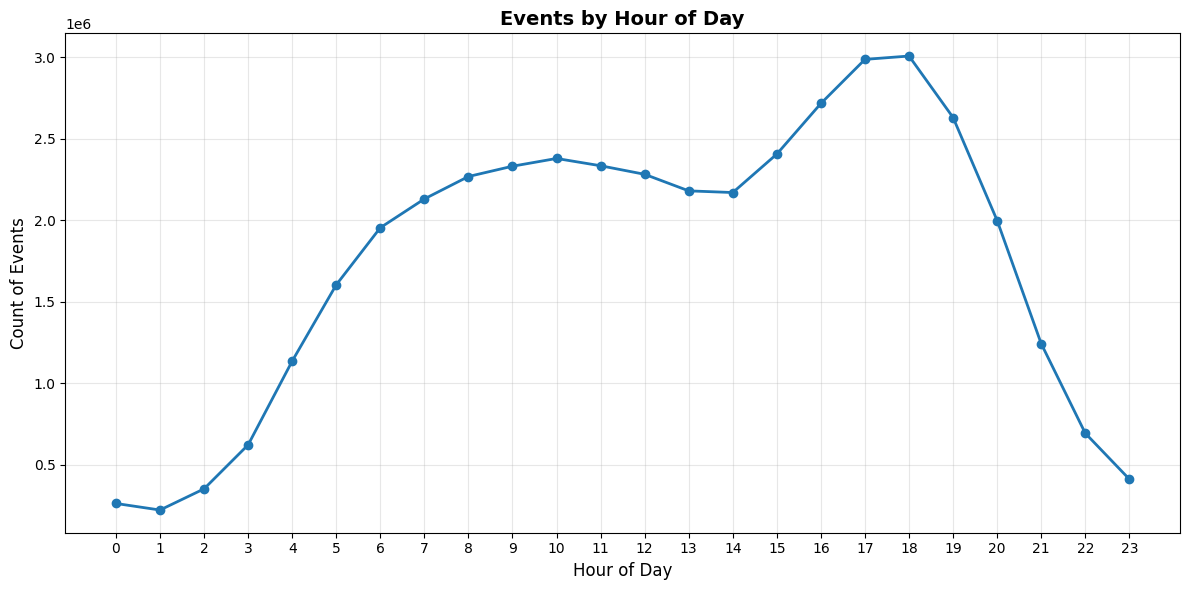

In [24]:


import matplotlib.pyplot as plt

events_by_hour_pdf = events_by_hour_df.toPandas()

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(events_by_hour_pdf['hour'], events_by_hour_pdf['count'], marker='o', linewidth=2, markersize=6)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Count of Events', fontsize=12)
plt.title('Events by Hour of Day', fontsize=14, fontweight='bold')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [25]:

# SQL Query to find average purchase price by brand (> 10K), sorted descending
sql_query = """
SELECT 
    b.brand_code,
    ROUND(AVG(e.price), 2) as avg_price
FROM events e
INNER JOIN brands b ON e.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
GROUP BY b.brand_code
HAVING AVG(e.price) > 10000
ORDER BY avg_price DESC
"""

results = spark.sql(sql_query)

results.show()

+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam|  58946.0|
|      kona|  43759.0|
|  yuandong|  35329.0|
|   bentley|  23164.0|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+



In [26]:

# DataFrame approach to find average purchase price by brand (> 10K)
avg_price_by_brand_df = (events_df
    .filter(events_df.event_type == 'purchase')
    .join(brands_df, events_df.brand_key == brands_df.brand_key, 'inner')
    .groupBy('brand_code')
    .agg(F.round(F.avg('price'), 2).alias('avg_price'))
    .filter(F.col('avg_price') > 10000)
    .orderBy(F.desc('avg_price'))
)

avg_price_by_brand_df.show()

+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam|  58946.0|
|      kona|  43759.0|
|  yuandong|  35329.0|
|   bentley|  23164.0|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+



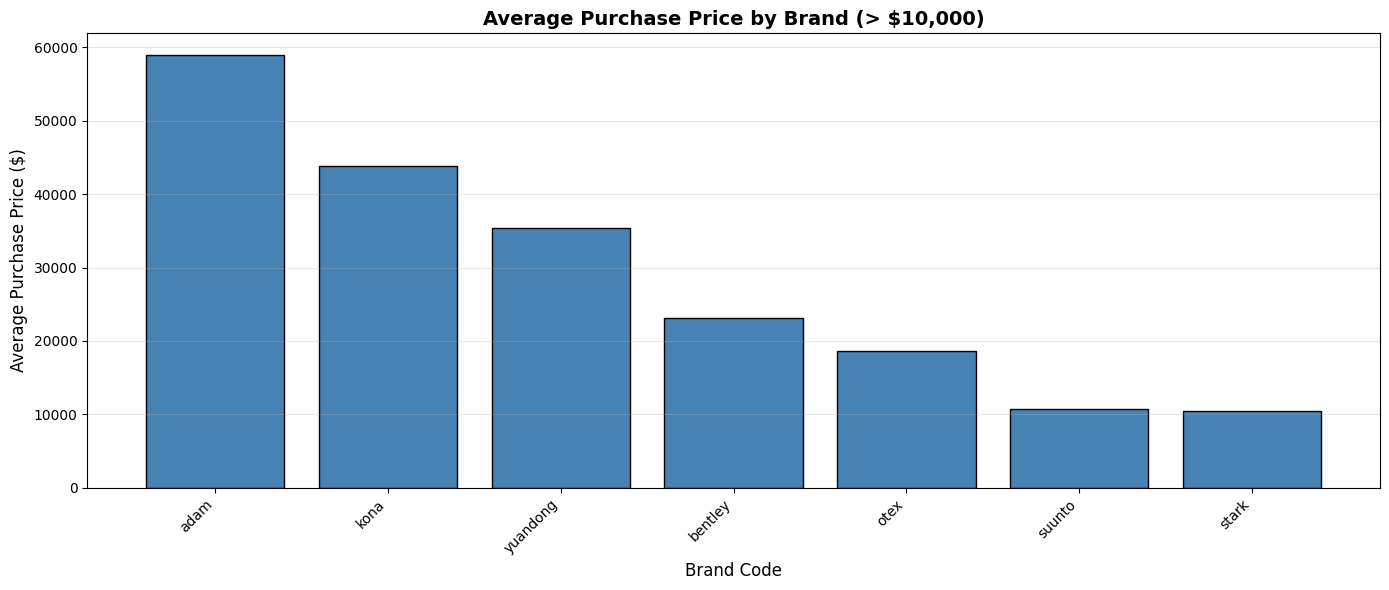

In [27]:

import matplotlib.pyplot as plt

avg_price_by_brand_pdf = avg_price_by_brand_df.toPandas()

# Plot the bar chart
plt.figure(figsize=(14, 6))
plt.bar(avg_price_by_brand_pdf['brand_code'], avg_price_by_brand_pdf['avg_price'], color='steelblue', edgecolor='black')
plt.xlabel('Brand Code', fontsize=12)
plt.ylabel('Average Purchase Price ($)', fontsize=12)
plt.title('Average Purchase Price by Brand (> $10,000)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

plt.show()

In [28]:
# Import Row from pyspark.sql
from pyspark.sql import Row

# Get RDDs directly from DataFrames (with required repartitions)
# type: RDD[Row]
events_rdd   = events_df.rdd.repartition(1000)
products_rdd = products_df.rdd.repartition(100)
brands_rdd   = brands_df.rdd.repartition(100)

print("RDDs loaded successfully!")
print(f"events_rdd partitions: {events_rdd.getNumPartitions()}")
print(f"products_rdd partitions: {products_rdd.getNumPartitions()}")
print(f"brands_rdd partitions: {brands_rdd.getNumPartitions()}")

RDDs loaded successfully!
events_rdd partitions: 1000
products_rdd partitions: 100
brands_rdd partitions: 100


In [29]:
filtered_events_df = (
    events_df
        .filter((F.col("event_type") == "purchase") & F.col("price").isNotNull())
        .join(brands_df, on="brand_key")
)

filtered_events_rdd = filtered_events_df.rdd

print(f"Number of rows in events          table: {events_df.count()}")
print(f"Number of rows in filtered events table: {filtered_events_df.count()}")

Number of rows in events          table: 42351862


Number of rows in filtered events table: 664885


In [30]:

# Version 1: Using groupByKey() - shuffle all values
# Map: (brand_code, price)
# groupByKey: (brand_code, [prices...])
# Reduce: calculate average per brand

average_revenue_per_brand_v1 = (
    filtered_events_rdd
    .map(lambda row: (row.brand_code, row.price))  # Extract brand_code and price
    .groupByKey()  # Group all prices by brand_code
    .map(lambda x: (
        x[0],  # brand_code
        round(sum(x[1]) / len(x[1]), 2)  # Calculate average and round to 2 decimals
    ))
    .sortBy(lambda x: -x[1])  # Sort by average price descending
)

average_revenue_per_brand_v1.take(10)

[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

In [31]:


# Version 3: Using reduceByKey() - early aggregation with (sum, count) pairs
# Map: (brand_code, (price, 1))
# reduceByKey: (brand_code, (sum, count))
# Map: calculate average

average_revenue_per_brand_v3 = (
    filtered_events_rdd
    .map(lambda row: (row.brand_code, (row.price, 1)))  # (brand_code, (price, 1))
    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))  # (brand_code, (sum, count))
    .map(lambda x: (
        x[0],  # brand_code
        round(x[1][0] / x[1][1], 2)  # Calculate average and round to 2 decimals
    ))
    .sortBy(lambda x: -x[1])  # Sort by average price descending
)

average_revenue_per_brand_v3.take(10)

[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

In [32]:
# codecell_61a

def shuffle_join(R, S, keyR, keyS):
    """
    Perform a shuffle join (reduce-side join) between two RDDs.
    
    Args:
        R: First RDD with Row objects
        S: Second RDD with Row objects
        keyR: Name of join key column in R (string)
        keyS: Name of join key column in S (string)
    
    Returns:
        RDD of joined Rows (inner join)
    """
    
    # Step 1: Map R to (key, ('R', row))
    R_mapped = R.map(lambda row: (row[keyR], ('R', row)))
    
    # Step 2: Map S to (key, ('S', row))
    S_mapped = S.map(lambda row: (row[keyS], ('S', row)))
    
    # Step 3: Union the two RDDs
    union_rdd = R_mapped.union(S_mapped)
    
    # Step 4: Group by key (shuffle happens here)
    grouped = union_rdd.groupByKey()
    
    # Step 5: Perform the join logic
    def join_rows(key, values):
        """Join rows with the same key"""
        R_rows = [v[1] for v in values if v[0] == 'R']
        S_rows = [v[1] for v in values if v[0] == 'S']
        
        # Inner join: produce result for each pair (r, s)
        results = []
        for r in R_rows:
            for s in S_rows:
                # Concatenate rows but keep only one copy of the join key
                # Create a new Row combining both rows
                combined = Row(**{**r.asDict(), **s.asDict()})
                results.append(combined)
        
        return results
    
    # Step 6: Apply join logic and flatten results
    joined = grouped.flatMap(lambda item: join_rows(item[0], item[1]))
    
    return joined

In [33]:

# Perform shuffle join between brands and products
shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key")
total_count = shuffle_join_rdd.count()
print(f"Total joined rows: {total_count}")

Total joined rows: 115584


In [34]:
# Add WHERE clause to filter by brand_key
shuffle_join_results_rdd = shuffle_join_rdd.filter(lambda row: row["brand_key"] == "423")
filtered_count = shuffle_join_results_rdd.count()
print(f"Filtered rows (brand_key = 423): {filtered_count}")

Filtered rows (brand_key = 423): 0


In [35]:
# Vérifier d'abord les données brutes
print("First 5 rows from shuffle_join_rdd:")
shuffle_join_rdd.take(5)

# Le filtre doit utiliser le bon type de donnée
shuffle_join_results_rdd = shuffle_join_rdd.filter(lambda row: str(row["brand_key"]) == "423")
filtered_count = shuffle_join_results_rdd.count()
print(f"Filtered rows (brand_key = 423): {filtered_count}")

# Convert RDD results to DataFrame for pretty printing
if filtered_count > 0:
    df = spark.createDataFrame(shuffle_join_results_rdd.collect())
    df.show(truncate=False)
else:
    print("No rows found. Checking all brand_keys in the result...")
    all_rows = shuffle_join_rdd.take(10)
    for row in all_rows:
        print(f"brand_key: {row['brand_key']}, type: {type(row['brand_key'])}")

First 5 rows from shuffle_join_rdd:


Filtered rows (brand_key = 423): 2


+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------+----------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [36]:
# Convert RDD results to DataFrame for pretty printing
df = spark.createDataFrame(shuffle_join_results_rdd.collect())
df.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------+----------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
# SQL reference query
sql_reference = spark.sql("""
SELECT * FROM brands b
JOIN products p ON p.brand_key = b.brand_key
WHERE b.brand_key = '423'
""")

print("SQL Reference Query Results:")
sql_reference.show(truncate=False)

print(f"\nExpected rows: {sql_reference.count()}")

SQL Reference Query Results:
+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------+----------+----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [38]:
# codecell_62a

def replicated_hash_join(R, S, keyR, keyS):
    """
    Perform a replicated hash join (broadcast hash join) between two RDDs.
    
    Args:
        R: First RDD with Row objects (will be replicated/broadcast)
        S: Second RDD with Row objects (streaming side)
        keyR: Name of join key column in R (string)
        keyS: Name of join key column in S (string)
    
    Returns:
        RDD of joined Rows (inner join)
    """
    
    # Step 1: Collect R into memory and build a hash map (dictionary)
    # Dictionary: {key_value: [rows...]}
    R_collected = R.collect()
    R_hash_map = {}
    
    for row in R_collected:
        key = row[keyR]
        if key not in R_hash_map:
            R_hash_map[key] = []
        R_hash_map[key].append(row)
    
    # Step 2: Broadcast the hash map to all workers
    R_broadcast = S.context.broadcast(R_hash_map)
    
    # Step 3: For each row in S, look up matching rows in R using the broadcast map
    def join_with_broadcast(s_row):
        """
        Look up s_row's key in the broadcast R hash map.
        Return all joined pairs.
        """
        s_key = s_row[keyS]
        r_hash_map = R_broadcast.value
        
        # Look up in the hash map
        if s_key in r_hash_map:
            r_rows = r_hash_map[s_key]
        else:
            r_rows = []
        
        # Inner join: produce result for each matching pair (r, s)
        results = []
        for r_row in r_rows:
            # Merge both rows, keeping only one copy of the join key
            merged_dict = {**r_row.asDict(), **s_row.asDict()}
            merged_dict[keyR] = s_key  # Keep one copy of the key
            combined = Row(**merged_dict)
            results.append(combined)
        
        return results
    
    # Step 4: Apply the join function using flatMap
    joined = S.flatMap(join_with_broadcast)
    
    return joined

In [39]:


# Perform replicated hash join between brands and products
replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key")
total_count = replicated_hash_join_rdd.count()
print(f"Total joined rows: {total_count}")

Total joined rows: 115584


In [40]:
# Add WHERE clause to filter by brand_key
replicated_hash_join_results_rdd = replicated_hash_join_rdd.filter(lambda row: str(row["brand_key"]) == "423")
filtered_count = replicated_hash_join_results_rdd.count()
print(f"Filtered rows (brand_key = 423): {filtered_count}")

Filtered rows (brand_key = 423): 2


In [41]:
# Convert RDD results to DataFrame for pretty printing
if filtered_count > 0:
    df = spark.createDataFrame(replicated_hash_join_results_rdd.collect())
    df.show(truncate=False)
else:
    print("No rows found after filtering")

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------+----------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
# SQL reference query
sql_reference = spark.sql("""
SELECT * FROM brands b
JOIN products p ON p.brand_key = b.brand_key
WHERE b.brand_key = '423'
""")

print("SQL Reference Query Results:")
sql_reference.show(truncate=False)

print(f"\nExpected rows: {sql_reference.count()}")

print("\n" + "="*70)
print("Replicated Hash Join Results:")
print("="*70)
df.show(truncate=False)

SQL Reference Query Results:
+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------+----------+----------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [43]:

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
shuffle_join_rdd.count()

2